# Introduction
For this project we will use a LSTM aprouch to analyses tweets in order to determ if they represent an emergency that is happening in real life. Our machine learn algorith will use labels to categorize the data, and determ which expressions may be related to real disasters.
We will start our project by importing the needed librarys. For our NLP we will use tensorflow Keras.

In [12]:
import numpy as np
import pandas as pd
from keras import preprocessing
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding, LSTM, Dense, Dropout,BatchNormalization
from keras.models import Sequential
import tensorflow as tf
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

## Exploratory Data Analysis
We will start our analysis by observing the data on each dataset (train and test).

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
df_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [8]:
df_train.drop('location', axis=1, inplace=True)
df_test.drop('location', axis=1, inplace=True)
df_train.drop('keyword', axis=1, inplace=True)
df_test.drop('keyword', axis=1, inplace=True)

We could observe that both datasets has null values on the location and keyword collumns, however thouse wouldn't be use on our analyses, so we desided to drop both. We than opted for observing how the labels are distributed.

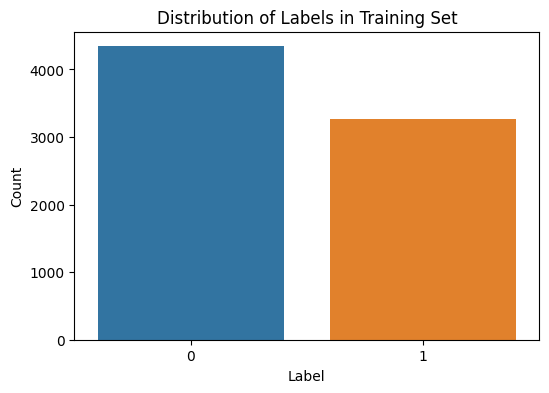

In [13]:
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df_train)
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

The graph show that the there are more non-emergencys tweets, what may cause over fitting of the data for the negatives cases. We should keep that in mind when training our model. We may choose to split the data evenly. 

## Pre-processing
We decided to pre-process the data by transforming the text and target collumns in and array, than removing potuation, stop words, any html and any emojis. We also balance the data between non-emergencys and emergencys tweets.

In [38]:
class_0 = df_train[df_train['target'] == 0]
class_1 = df_train[df_train['target'] == 1]
class_0_under = class_0.sample(len(class_1), random_state=42)
df_train = pd.concat([class_0_under, class_1])

In [39]:
text = df_train['text']
text = text.to_numpy()
label = df_train['target']
label = label.to_numpy()
text

array(['Everyday is a near death fatality for me on the road. Thank god is on my side.??',
       '#Lifestyle \x89Û÷It makes me sick\x89Ûª: Baby clothes deemed a \x89Û÷hazard\x89Ûª http://t.co/0XrfVidxA2 http://t.co/oIHwgEZDCk',
       '@Lenn_Len Probably. We are inundated with them most years!', ...,
       'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

In [40]:
def clean(text_array):
    def process_sentence(sentence):
        sentence = re.sub(r'http\S+|www\S+|https\S+', '', sentence, flags=re.MULTILINE)
        sentence = re.sub(r'#\S+', '', sentence)
        sentence = sentence.translate(str.maketrans('', '', string.punctuation))
        words = sentence.split()
        filtered_words = [word for word in words if word.lower() not in ENGLISH_STOP_WORDS]
        return ' '.join(filtered_words)
    return [process_sentence(sentence) for sentence in text_array]
text = clean(text)

In [41]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")
text = [stemmer.stem(word) for word in text]

We than tokenizer the words, so the algorith could process the sentences.

In [42]:
word_tokenizer = tf.keras.preprocessing.text.Tokenizer()
word_tokenizer.fit_on_texts(text)
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

15369

In [43]:
from nltk.tokenize import word_tokenize
longest_train = max(text, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

## Modeling
We than creat our modell and fit our data. We use a Binary Crossentropy loss, since our labels are binary, and our optimizer was Adamax, since we try other and we had the best accuracy results with it. We than fit the data with our clean and optimized texts.

In [44]:
max_words = vocab_length
max_len = length_long_sentence
sequences = word_tokenizer.texts_to_sequences(text)

padded_sequences = pad_sequences(sequences, maxlen=max_len)
labels = to_categorical(label)

model = Sequential()
model.add(Embedding(max_words, 128))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='BinaryCrossentropy', optimizer='Adamax', metrics=['accuracy'])

model.fit(padded_sequences, labels, epochs=10, batch_size=64)

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5452 - loss: 0.6880
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6576 - loss: 0.6265
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7853 - loss: 0.4731
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8172 - loss: 0.3977
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8428 - loss: 0.3609
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8604 - loss: 0.3343
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8718 - loss: 0.3067
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8860 - loss: 0.2767
Epoch 9/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8956 - loss: 0.2606
Epoch 10/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9056 - loss: 0.2390


## Conclusions
Now that our model is finalized, it is time to creat predictions using it. For that we will clean the test that set, and use the texts from there to creat new labels.

In [46]:
text2 = df_test['text']
text2 = text2.to_numpy()
text2 = clean(text2)
text2 = [stemmer.stem(word) for word in text2]
sequences2 = word_tokenizer.texts_to_sequences(text2)
padded_sequences2 = pad_sequences(sequences2, maxlen=max_len)

In [47]:
predictions = model.predict(padded_sequences2)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


We than creat our finall dataset. Using the predictions that we get, we calculated if they had a probability of 0.5 or more, than they will be an 1 or positive. Other wayse they will be a 0 or negative.

In [49]:
prob_class_1 = predictions[:, 1]
binary_predictions = [1 if p >= 0.5 else 0 for p in prob_class_1]
df = pd.DataFrame({'target': binary_predictions}, index=df_test['id'])
df.index.name = 'id'
df.to_csv('/kaggle/working/submission.csv')

Observing the distribution of our final data, we can observe that there are more cases of non-emergencys, but that was expected. Running our code on the submission, we got a score of 0.78057, what showes that our code is efficiant.

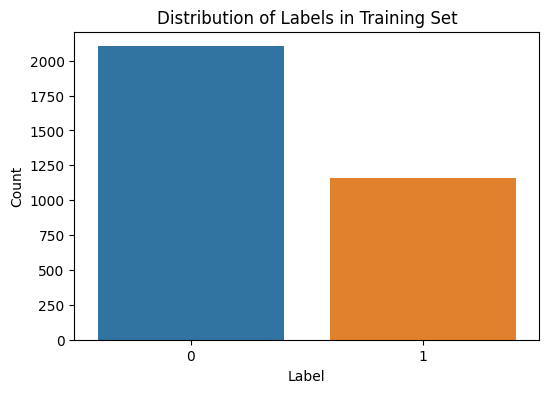

In [50]:
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()